## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys

import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import yaml
import logging
import logging.config
from easydict import EasyDict as edict

AI_CODE_BASE_PATH = '/codehub'
BASE_PATH_CONFIG = os.path.join(AI_CODE_BASE_PATH,'config')
APP_ROOT_DIR = os.path.join(AI_CODE_BASE_PATH,'apps')

if APP_ROOT_DIR not in sys.path:
  sys.path.insert(0, APP_ROOT_DIR)

import _cfg_
from falcon.arch import Model
import apputil
import viz
import common

from _log_ import logcfg
log = logging.getLogger(__name__)
logging.config.dictConfig(logcfg)

appcfg = _cfg_.load_appcfg(BASE_PATH_CONFIG)
appcfg = edict(appcfg)

# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
# from mrcnn.model import log

import tensorflow as tf
from keras.backend import tensorflow_backend

%matplotlib inline 

/virtualmachines/virtualenvs/py_3_20191211_1656/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/virtualmachines/virtualenvs/py_3_20191211_1656/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/virtualmachines/virtualenvs/py_3_20191211_1656/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/virtua

2020-01-09 14:58:03,408:[DEBUG]:[__main__._cfg_]:[_cfg_.py:188 -          load_appcfg() ]: appcfg: {'PATHS': {'AI_AIDS_DB': '/aimldl-dat/data-gaze/AIML_Aids', 'AI_ANNON_DATA_HOME': '/data/samba/Bangalore/prod/Bangalore_Maze_Exported_Data/ANNOTATIONS', 'AI_ANNON_DATA_HOME_LOCAL': '/aimldl-dat/data-gaze/AIML_Annotation/ods_merged_on_281219_125647', 'AI_ANNON_DB': '/aimldl-dat/data-gaze/AIML_Database', 'AI_ANNON_HOME': '/codehub/apps/annon', 'AI_APP': '/codehub/apps', 'AI_CFG': '/codehub/cfg', 'AI_CONFIG': '/codehub/config', 'AI_DATA': '/aimldl-dat', 'AI_DATA_GAZE': '/aimldl-dat/data-gaze', 'AI_DOC': '/aimldl-doc', 'AI_GOOGLE_APPLICATION_CREDENTIALS': '/codehub/auth/', 'AI_HOME': '/codehub', 'AI_HOME_EXT': '/codehub/external', 'AI_KBANK': '/aimldl-kbank', 'AI_LANENET_ROOT': '/codehub/external/lanenet-lane-detection', 'AI_LOGS': '/aimldl-dat/logs', 'AI_MNT': '/aimldl-mnt', 'AI_MODEL_CFG_PATH': '/codehub/cfg/model', 'AI_PYVER': '3', 'AI_PY_ENVVARS': 'AI_APP:AI_HOME_EXT:MASK_RCNN:FASTER_RCNN

Using TensorFlow backend.


In [2]:
def get_modelcfg(cfg, modelinfo_filepath):
    modelcfg = _cfg_.load_yaml(modelinfo_filepath)
    if type(modelcfg) != type([]):
        ## quick fix for name not present in config
        if modelcfg and modelcfg['config']:
            if 'name' in modelcfg:
                modelcfg['config']['NAME'] = modelcfg['name']
            if 'num_classes' in modelcfg:
                modelcfg['config']['NUM_CLASSES'] = modelcfg['num_classes']
            
            weights_path = apputil.get_abs_path(cfg, modelcfg, 'AI_WEIGHTS_PATH')
            modelcfg['weights_path'] = weights_path

    return modelcfg


def load_model(cfg, modelinfo_filepath):
    modelcfg = get_modelcfg(cfg, modelinfo_filepath)
    log.debug("modelcfg: {}".format(modelcfg))

    if modelcfg:
        mode = modelcfg['mode']
        dnnarch = modelcfg['dnnarch']
        dnnmod = apputil.get_module(dnnarch)
        load_model_and_weights = apputil.get_module_fn(dnnmod, "load_model_and_weights")
        
        ##modelcfg['log_dir'] = log_dir
        log_dir_path = apputil.get_abs_path(cfg, modelcfg, 'AI_LOGS')
        weights_path = apputil.get_abs_path(cfg, modelcfg, 'AI_WEIGHTS_PATH')
        modelcfg['log_dir_path'] = log_dir_path
        modelcfg['weights_path'] = weights_path
        
        model = load_model_and_weights(mode, modelcfg, cfg)
        print("model: {}".format(model))
    return model, modelcfg


In [3]:
MODELINFO_FILEPATH = '/codehub/cfg/model/release/vidteq-ods-7-mask_rcnn.yml'
HOST = "10.4.71.69"
AI_ANNON_DATA_HOME_LOCAL ="/aimldl-dat/data-gaze/AIML_Annotation/ods_job_230119"

cmd = "train"
dbname = "PXL-291119_180404"
exp_id = "train-422d30b0-f518-4203-9c4d-b36bd8796c62"
subset = "val"

eval_on = subset

In [4]:
# tf.keras.backend.clear_session()  # For easy reset of notebook state.

## Load Configurations

In [5]:
appcfg['APP']['DBCFG']['PXLCFG']['host'] = HOST
appcfg['PATHS']['AI_ANNON_DATA_HOME_LOCAL'] = AI_ANNON_DATA_HOME_LOCAL

# log.debug(appcfg)
# log.info(appcfg['APP']['DBCFG']['PXLCFG'])
# log.info(appcfg['PATHS']['AI_ANNON_DATA_HOME_LOCAL'])

In [6]:
## datacfg and dbcfg
_cfg_.load_datacfg(cmd, appcfg, dbname, exp_id, eval_on)
datacfg = apputil.get_datacfg(appcfg)
dbcfg = apputil.get_dbcfg(appcfg)

# log.info("datacfg: {}".format(datacfg))
# log.info("dbcfg: {}".format(dbcfg))

2020-01-09 14:58:07,402:[DEBUG]:[__main__._cfg_]:[_cfg_.py:65 -         load_datacfg() ]: ----------------------------->
2020-01-09 14:58:07,405:[DEBUG]:[__main__._cfg_]:[_cfg_.py:66 -         load_datacfg() ]: cmd, appcfg, dbname, exp_id, eval_on:  train, {'PATHS': {'AI_AIDS_DB': '/aimldl-dat/data-gaze/AIML_Aids', 'AI_ANNON_DATA_HOME': '/data/samba/Bangalore/prod/Bangalore_Maze_Exported_Data/ANNOTATIONS', 'AI_ANNON_DATA_HOME_LOCAL': '/aimldl-dat/data-gaze/AIML_Annotation/ods_job_230119', 'AI_ANNON_DB': '/aimldl-dat/data-gaze/AIML_Database', 'AI_ANNON_HOME': '/codehub/apps/annon', 'AI_APP': '/codehub/apps', 'AI_CFG': '/codehub/cfg', 'AI_CONFIG': '/codehub/config', 'AI_DATA': '/aimldl-dat', 'AI_DATA_GAZE': '/aimldl-dat/data-gaze', 'AI_DOC': '/aimldl-doc', 'AI_GOOGLE_APPLICATION_CREDENTIALS': '/codehub/auth/', 'AI_HOME': '/codehub', 'AI_HOME_EXT': '/codehub/external', 'AI_KBANK': '/aimldl-kbank', 'AI_LANENET_ROOT': '/codehub/external/lanenet-lane-detection', 'AI_LOGS': '/aimldl-dat/logs'

In [7]:
## archcfg, cmdcfg

_cfg_.load_archcfg(cmd, appcfg, dbname, exp_id, eval_on)
archcfg = apputil.get_archcfg(appcfg)
log.debug("archcfg: {}".format(archcfg))
cmdcfg = archcfg

2020-01-09 14:58:10,426:[DEBUG]:[__main__._cfg_]:[_cfg_.py:119 -         load_archcfg() ]: ----------------------------->
2020-01-09 14:58:10,428:[DEBUG]:[__main__._cfg_]:[_cfg_.py:150 -         load_archcfg() ]: DBCFG: {'ANNONCFG': {'annon_type': 'hmd', 'class_ids': None, 'data_read_threshold': -1, 'dataclass': 'AnnonDataset', 'dbname': 'annon_v11', 'host': '10.4.71.69', 'name': 'hmd', 'password': '', 'port': 27017, 'return_hmd': None, 'username': ''}, 'CBIRCFG': {'dbname': 'eka', 'host': '10.4.71.69', 'password': '', 'port': 27017, 'username': ''}, 'OASISCFG': {'annon_type': 'hmd', 'class_ids': None, 'data_read_threshold': -1, 'dataclass': 'AnnonDataset', 'dbname': 'oasis', 'host': '10.4.71.69', 'name': 'hmd', 'password': '', 'port': 27017, 'return_hmd': None, 'username': ''}, 'PXLCFG': {'annon_type': 'hmd', 'class_ids': None, 'data_read_threshold': -1, 'dataclass': 'AnnonDataset', 'dbname': 'PXL-291119_180404', 'host': '10.4.71.69', 'name': 'hmd', 'password': '', 'port': 27017, 'ret

In [8]:
## dnncfg
dnnmod = apputil.get_module(cmdcfg.dnnarch)
get_dnncfg = apputil.get_module_fn(dnnmod, "get_dnncfg")
dnncfg = get_dnncfg(cmdcfg.config)
print(dnncfg)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                13
IMAGE_MIN_DIM                  720
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [9]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Model

In [10]:
model, modelinfo = load_model(appcfg, MODELINFO_FILEPATH)

2020-01-09 14:58:21,802:[DEBUG]:[__main__]:[<ipython-input-2-115b8b786e54>:19 -           load_model() ]: modelcfg: {'checkpoint_path': '/aimldl-dat/logs/mask_rcnn/281119_154803/train_hmd_031219_071805/mask_rcnn_hmd_{epoch:04d}.h5', 'classes': ['BG', 'signage', 'traffic_light', 'traffic_sign'], 'classinfo': None, 'config': {'DETECTION_MIN_CONFIDENCE': 0.9, 'GPU_COUNT': 1, 'IMAGES_PER_GPU': 1, 'IMAGE_MAX_DIM': 1280, 'IMAGE_MIN_DIM': 720, 'STEPS_PER_EPOCH': 1000, 'NAME': 'hmd', 'NUM_CLASSES': 4}, 'creator': 'AIE1', 'dataset': 'PXL-281119_154739', 'dbname': 'PXL-281119_154739', 'dnnarch': 'mask_rcnn', 'framework_type': 'keras', 'id': None, 'load_weights': {'by_name': True, 'exclude': ['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask']}, 'log_dir': '/aimldl-dat/logs/mask_rcnn/281119_154803/train_hmd_031219_071805', 'mode': 'inference', 'model_info': 'vidteq-hmd-031219_071805-mask_rcnn.yml', 'name': 'hmd', 'num_classes': 4, 'org_name': 'vidteq', 'problem_id': 'ods', 'rel_num

2020-01-09 14:58:21,846:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: POST_NMS_ROIS_INFERENCE: 1000
2020-01-09 14:58:21,847:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: POST_NMS_ROIS_TRAINING: 2000
2020-01-09 14:58:21,848:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: PRE_NMS_LIMIT: 6000
2020-01-09 14:58:21,849:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: ROI_POSITIVE_RATIO: 0.33
2020-01-09 14:58:21,850:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: RPN_ANCHOR_RATIOS: [0.5, 1, 2]
2020-01-09 14:58:21,851:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: RPN_ANCHOR_SCALES: (32, 64, 128, 256, 512)
2020-01-09 14:58:21,851:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: RPN_ANCHOR_STRIDE: 1
2020-01-09 14:58:21,853:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: RPN_BBOX_STD_DEV:

2020-01-09 14:58:21,935:[WARNING]:[tensorflow]:[deprecation.py:323 -             new_func() ]: From /virtualmachines/virtualenvs/py_3_20191211_1656/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2020-01-09 14:58:25,584:[DEBUG]:[__main__.mrcnn.model]:[model.py:2006 -                build() ]: output_names, outputs: ['rpn_class_logits', 'rpn_class', 'rpn_bbox'], [<tf.Tensor 'rpn_class_logits/concat:0' shape=(?, ?, 2) dtype=float32>, <tf.Tensor 'rpn_class/concat:0' shape=(?, ?, 2) dtype=float32>, <tf.Tensor 'rpn_bbox/concat:0' shape=(?, ?, 4) dtype=float32>]
Instructions for updating:
Use tf.cast instead.
2020-01-09 14:58:26,197:[WARNING]:[tensorflow]:[deprecation.py:323 -             new_func() ]: From /codehub/external/Mask_RCNN/mrcnn/model.py:809: to_float (from tensorflow.pyth

In [11]:
model.keras_model.layers

In [12]:
# # Model
# inputs = [input_image, input_image_meta, 
#           input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_masks]
# if not config.USE_RPN_ROIS:
#     inputs.append(input_rois)
# outputs = [rpn_class_logits, rpn_class, rpn_bbox,
#            mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
#            rpn_rois, output_rois,
#            rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss]
# model = KM.Model(inputs, outputs, name='mask_rcnn')

print("summary:---------------")
print(model.keras_model.summary())
print("\ninput:---------------")
print(model.keras_model.inputs)
print("\noutput:---------------")
print(model.keras_model.outputs)

summary:---------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
_____________________________________________________________________________________

In [13]:
print(modelinfo['log_dir'])

/aimldl-dat/logs/mask_rcnn/281119_154803/train_hmd_031219_071805


In [14]:
modelinfo = get_modelcfg(appcfg, MODELINFO_FILEPATH)
weights_path = modelinfo['weights_path']
print(weights_path)

# weights_path = "/aimldl-dat/logs/mask_rcnn/101219_190844/train_hmd_121219_081328/mask_rcnn_hmd_0024.h5"

/aimldl-dat/release/vidteq/ods/7/mask_rcnn/weights/mask_rcnn_hmd_0120.h5


## Load Validation Dataset

In [15]:
dataset, num_classes, num_images, class_names, total_stats, total_verify = apputil.get_dataset_instance(appcfg, dbcfg, datacfg, subset)
colors = viz.random_colors(len(class_names))

log.debug("class_names: {}".format(class_names))
log.debug("len(class_names): {}".format(len(class_names)))
log.debug("len(colors), colors: {},{}".format(len(colors), colors))
log.debug("num_classes: {}".format(num_classes))
log.debug("num_images: {}".format(num_images))

name = dataset.name
datacfg.name = name
datacfg.classes = class_names
datacfg.num_classes = num_classes

cmdcfg.name = name
cmdcfg.config.NAME = name
cmdcfg.config.NUM_CLASSES = num_classes

2020-01-09 14:58:46,164:[INFO]:[__main__.apputil]:[apputil.py:199 - get_dataset_instance() ]: -------------------------------->
2020-01-09 14:58:46,166:[DEBUG]:[__main__.apputil]:[apputil.py:200 - get_dataset_instance() ]: datacfg: {'created_on': '2019-11-29 18:04:13 +05:30', 'allowed_file_type': ['.txt', '.csv', '.yml', '.json'], 'allowed_image_type': ['.pdf', '.png', '.jpg', '.jpeg', '.gif'], 'allowed_video_type': ['.mp4'], 'annon_type': 'hmd', 'config': {'DETECTION_MIN_CONFIDENCE': 0.9, 'GPU_COUNT': 1, 'IMAGES_PER_GPU': 1, 'IMAGE_MAX_DIM': 1280, 'IMAGE_MIN_DIM': 720, 'STEPS_PER_EPOCH': 1000}, 'creator': 'AIE1', 'dataclass': 'AnnonDataset', 'dbname': 'PXL-291119_180404', 'device': '/gpu:0', 'dnnarch': 'mask_rcnn', 'filename': '281119_123250-AIE1-21-mask_rcnn.yml', 'filepath': '/aimldl-cfg/arch/281119_123250-AIE1-21-mask_rcnn.yml', 'framework_type': 'keras', 'load_weights': {'by_name': True, 'exclude': ['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask']}, 'log_dir': 'm

2020-01-09 14:58:46,324:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:121 -    load_data_from_db() ]: classinfo: [{'lbl_id': 'signage', 'name': 'signage', 'source': 'hmd'}, {'lbl_id': 'traffic_light', 'name': 'traffic_light', 'source': 'hmd'}, {'lbl_id': 'traffic_sign', 'name': 'traffic_sign', 'source': 'hmd'}]
2020-01-09 14:58:46,327:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:130 -    load_data_from_db() ]: len(release): 0
2020-01-09 14:58:46,331:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:168 -          createIndex() ]: -------------------------------->
2020-01-09 14:58:46,344:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:196 -          createIndex() ]: index created!
2020-01-09 14:58:46,345:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:55 -             __init__() ]: Done (t=0.16s)
2020-01-09 14:58:46,349:[DEBUG]:[__main__.falcon.utils.AnnonDataset]:[AnnonDataset.py:370 -             load_hmd() ]: subset, class_ids: val, ['signage', 'traffic_light', 'traffic_sign']
202

## Run Detection

image ID: hmd.hmd-img-253719a3-f23e-43dc-8a64-0370850d7162 (102) /aimldl-dat/data-gaze/AIML_Annotation/ods_job_230119/images/images-p1-230119_AT1/071218_095614_16716_zed_l_335.jpg
Processing 1 images
image                    shape: (1280, 1280, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.28306  max:    1.23302  float32
1/1 [==============================] - 7s 7s/step
2020-01-09 14:59:00,079:[DEBUG]:[__main__.mrcnn.model]:[model.py:2654 -               detect() ]: results: [{'rois': array([[314, 403, 368, 462]], dtype=int32), 'class_ids': array([3], dtype=int32), 'scores': array([0.9998574], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],



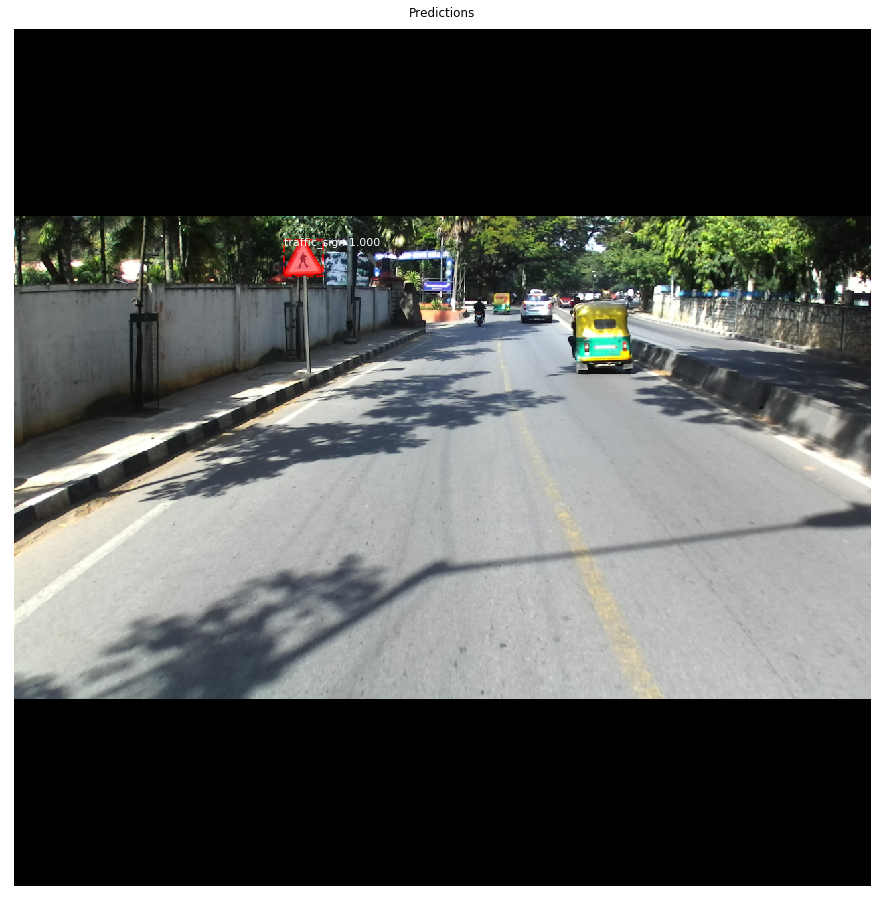

In [16]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, datacfg, dnncfg, image_id, use_mini_mask=False)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

### Precision-Recall

2020-01-09 14:59:08,110:[INFO]:[__main__.mrcnn.utils]:[utils.py:680 -      compute_matches() ]: sorted pred_scores: [0.9998574]
2020-01-09 14:59:08,114:[INFO]:[__main__.mrcnn.utils]:[utils.py:692 -      compute_matches() ]: sorted pred_scores: [0.9998574]
2020-01-09 14:59:08,116:[INFO]:[__main__.mrcnn.utils]:[utils.py:693 -      compute_matches() ]: len(pred_boxes), pred_boxes.shape: 1, (1, 4)
2020-01-09 14:59:08,117:[INFO]:[__main__.mrcnn.utils]:[utils.py:694 -      compute_matches() ]: len(pred_masks), pred_masks.shape: 1280, (1280, 1280, 1)
2020-01-09 14:59:08,118:[INFO]:[__main__.mrcnn.utils]:[utils.py:695 -      compute_matches() ]: len(gt_boxes), gt_boxes.shape: 2, (2, 4)
2020-01-09 14:59:08,119:[INFO]:[__main__.mrcnn.utils]:[utils.py:696 -      compute_matches() ]: len(gt_masks), gt_masks.shape: 1280, (1280, 1280, 2)
2020-01-09 14:59:08,122:[INFO]:[__main__.mrcnn.utils]:[utils.py:697 -      compute_matches() ]: gt_class_ids, pred_class_ids: [3 2], [3]
2020-01-09 14:59:08,161:[IN

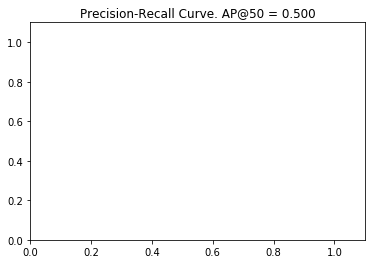

In [17]:
# Draw precision-recall curve
AP, precisions, recalls, gt_match, pred_match, overlaps, pred_match_scores, pred_match_class_ids = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.5)

visualize.plot_precision_recall(AP, precisions, recalls)

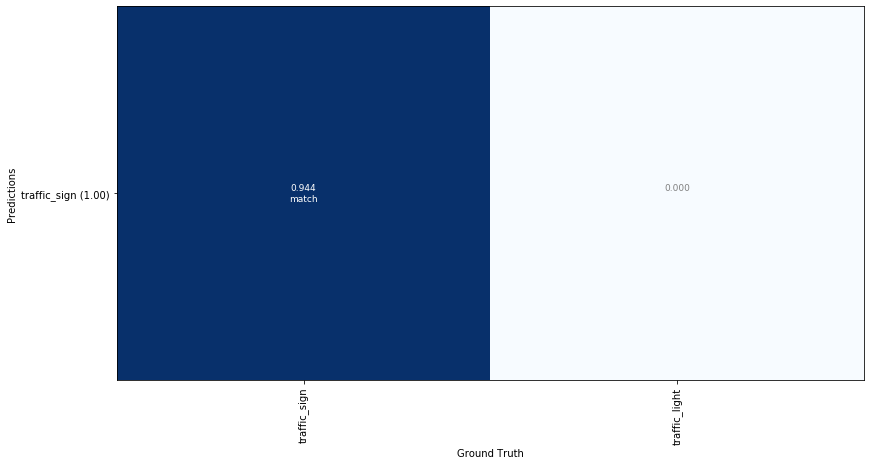

In [18]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [19]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, datacfg, dnncfg,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, gt_match, pred_match, overlaps, pred_match_scores, pred_match_class_ids =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

2020-01-09 14:59:34,262:[DEBUG]:[__main__.mrcnn.model]:[model.py:2654 -               detect() ]: results: [{'rois': array([[560, 586, 587, 600],
       [603, 600, 638, 621]], dtype=int32), 'class_ids': array([3, 1], dtype=int32), 'scores': array([0.9953129 , 0.95994216], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
     

2020-01-09 14:59:35,950:[INFO]:[__main__.mrcnn.utils]:[utils.py:680 -      compute_matches() ]: sorted pred_scores: [0.99980575 0.999281  ]
2020-01-09 14:59:35,955:[INFO]:[__main__.mrcnn.utils]:[utils.py:692 -      compute_matches() ]: sorted pred_scores: [0.99980575 0.999281  ]
2020-01-09 14:59:35,957:[INFO]:[__main__.mrcnn.utils]:[utils.py:693 -      compute_matches() ]: len(pred_boxes), pred_boxes.shape: 2, (2, 4)
2020-01-09 14:59:35,958:[INFO]:[__main__.mrcnn.utils]:[utils.py:694 -      compute_matches() ]: len(pred_masks), pred_masks.shape: 1280, (1280, 1280, 2)
2020-01-09 14:59:35,959:[INFO]:[__main__.mrcnn.utils]:[utils.py:695 -      compute_matches() ]: len(gt_boxes), gt_boxes.shape: 1, (1, 4)
2020-01-09 14:59:35,960:[INFO]:[__main__.mrcnn.utils]:[utils.py:696 -      compute_matches() ]: len(gt_masks), gt_masks.shape: 1280, (1280, 1280, 1)
2020-01-09 14:59:35,962:[INFO]:[__main__.mrcnn.utils]:[utils.py:697 -      compute_matches() ]: gt_class_ids, pred_class_ids: [3], [3 1]
202

2020-01-09 14:59:37,771:[INFO]:[__main__.mrcnn.utils]:[utils.py:697 -      compute_matches() ]: gt_class_ids, pred_class_ids: [1 2 3], [3 1 2]
2020-01-09 14:59:37,827:[INFO]:[__main__.mrcnn.utils]:[utils.py:700 -      compute_matches() ]: Mask IoU before filtering with threshold: overlaps: [[0.         0.         0.7232704 ]
 [0.8225539  0.00424328 0.        ]
 [0.00139665 0.569378   0.        ]]
2020-01-09 14:59:37,828:[INFO]:[__main__.mrcnn.utils]:[utils.py:727 -      compute_matches() ]: pred_class_ids[0] == gt_class_ids[2]: 3,3
2020-01-09 14:59:37,830:[INFO]:[__main__.mrcnn.utils]:[utils.py:727 -      compute_matches() ]: pred_class_ids[1] == gt_class_ids[0]: 1,1
2020-01-09 14:59:37,831:[INFO]:[__main__.mrcnn.utils]:[utils.py:727 -      compute_matches() ]: pred_class_ids[2] == gt_class_ids[1]: 2,2
2020-01-09 14:59:37,832:[INFO]:[__main__.mrcnn.utils]:[utils.py:734 -      compute_matches() ]: STATS: match_count: 3
2020-01-09 14:59:37,833:[INFO]:[__main__.mrcnn.utils]:[utils.py:735 

2020-01-09 14:59:39,653:[INFO]:[__main__.mrcnn.utils]:[utils.py:735 -      compute_matches() ]: gt_match, pred_match, overlaps, pred_match_class_ids: [-1.],[],[],[]
2020-01-09 14:59:39,655:[INFO]:[__main__.mrcnn.utils]:[utils.py:762 - compute_ap_given_the_matches() ]: precisions: [0. 0.]
2020-01-09 14:59:39,657:[INFO]:[__main__.mrcnn.utils]:[utils.py:763 - compute_ap_given_the_matches() ]: recalls: [0. 1.]
2020-01-09 14:59:39,663:[INFO]:[__main__.mrcnn.utils]:[utils.py:764 - compute_ap_given_the_matches() ]: indices: [1]
2020-01-09 14:59:39,665:[INFO]:[__main__.mrcnn.utils]:[utils.py:766 - compute_ap_given_the_matches() ]: precisions[indices]: [0.]
2020-01-09 14:59:39,666:[INFO]:[__main__.mrcnn.utils]:[utils.py:767 - compute_ap_given_the_matches() ]: recalls[indices:] [1.]
2020-01-09 14:59:39,668:[INFO]:[__main__.mrcnn.utils]:[utils.py:774 - compute_ap_given_the_matches() ]: AP: 0.0
2020-01-09 14:59:40,418:[DEBUG]:[__main__.mrcnn.model]:[model.py:2654 -               detect() ]: result

2020-01-09 14:59:42,040:[INFO]:[__main__.mrcnn.utils]:[utils.py:680 -      compute_matches() ]: sorted pred_scores: [0.9879468 0.9433937]
2020-01-09 14:59:42,044:[INFO]:[__main__.mrcnn.utils]:[utils.py:692 -      compute_matches() ]: sorted pred_scores: [0.9879468 0.9433937]
2020-01-09 14:59:42,046:[INFO]:[__main__.mrcnn.utils]:[utils.py:693 -      compute_matches() ]: len(pred_boxes), pred_boxes.shape: 2, (2, 4)
2020-01-09 14:59:42,047:[INFO]:[__main__.mrcnn.utils]:[utils.py:694 -      compute_matches() ]: len(pred_masks), pred_masks.shape: 1280, (1280, 1280, 2)
2020-01-09 14:59:42,048:[INFO]:[__main__.mrcnn.utils]:[utils.py:695 -      compute_matches() ]: len(gt_boxes), gt_boxes.shape: 1, (1, 4)
2020-01-09 14:59:42,049:[INFO]:[__main__.mrcnn.utils]:[utils.py:696 -      compute_matches() ]: len(gt_masks), gt_masks.shape: 1280, (1280, 1280, 1)
2020-01-09 14:59:42,050:[INFO]:[__main__.mrcnn.utils]:[utils.py:697 -      compute_matches() ]: gt_class_ids, pred_class_ids: [1], [1 3]
2020-01

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [20]:

from mrcnn.model import log

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (409200,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -9.33200  max:    3.86699  float64
positive_anchors         shape: (12, 4)               min:  304.00000  max:  906.62742  float64
negative_anchors         shape: (244, 4)              min: -181.01934  max: 1317.25483  float64
neutral anchors          shape: (408944, 4)           min: -362.03867  max: 1578.03867  float64
refined_anchors          shape: (12, 4)               min:  316.00000  max:  869.00000  float32


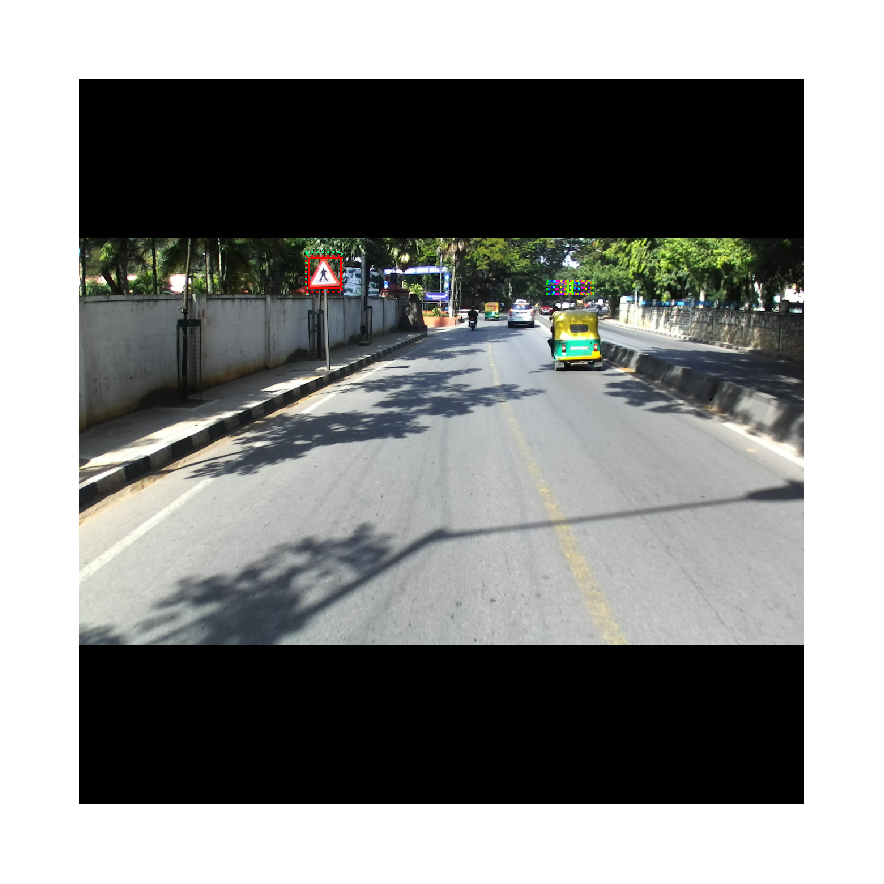

In [21]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [22]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 409200, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.28306  max:    1.23302  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.77915  max:    1.46634  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 2079.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


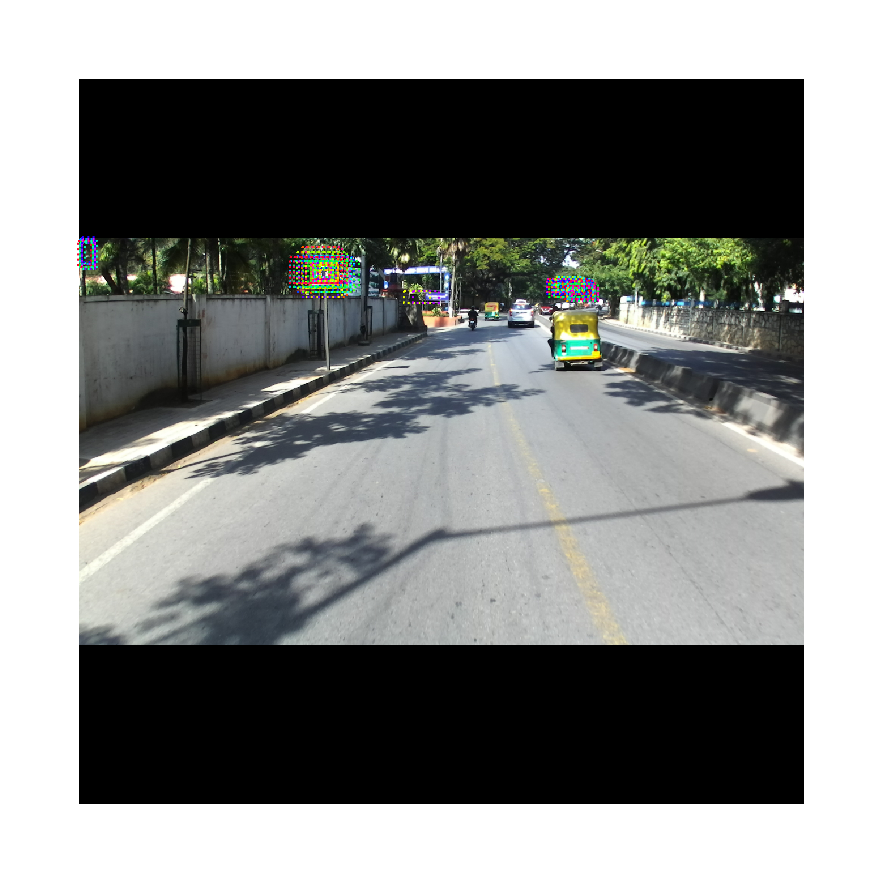

In [23]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

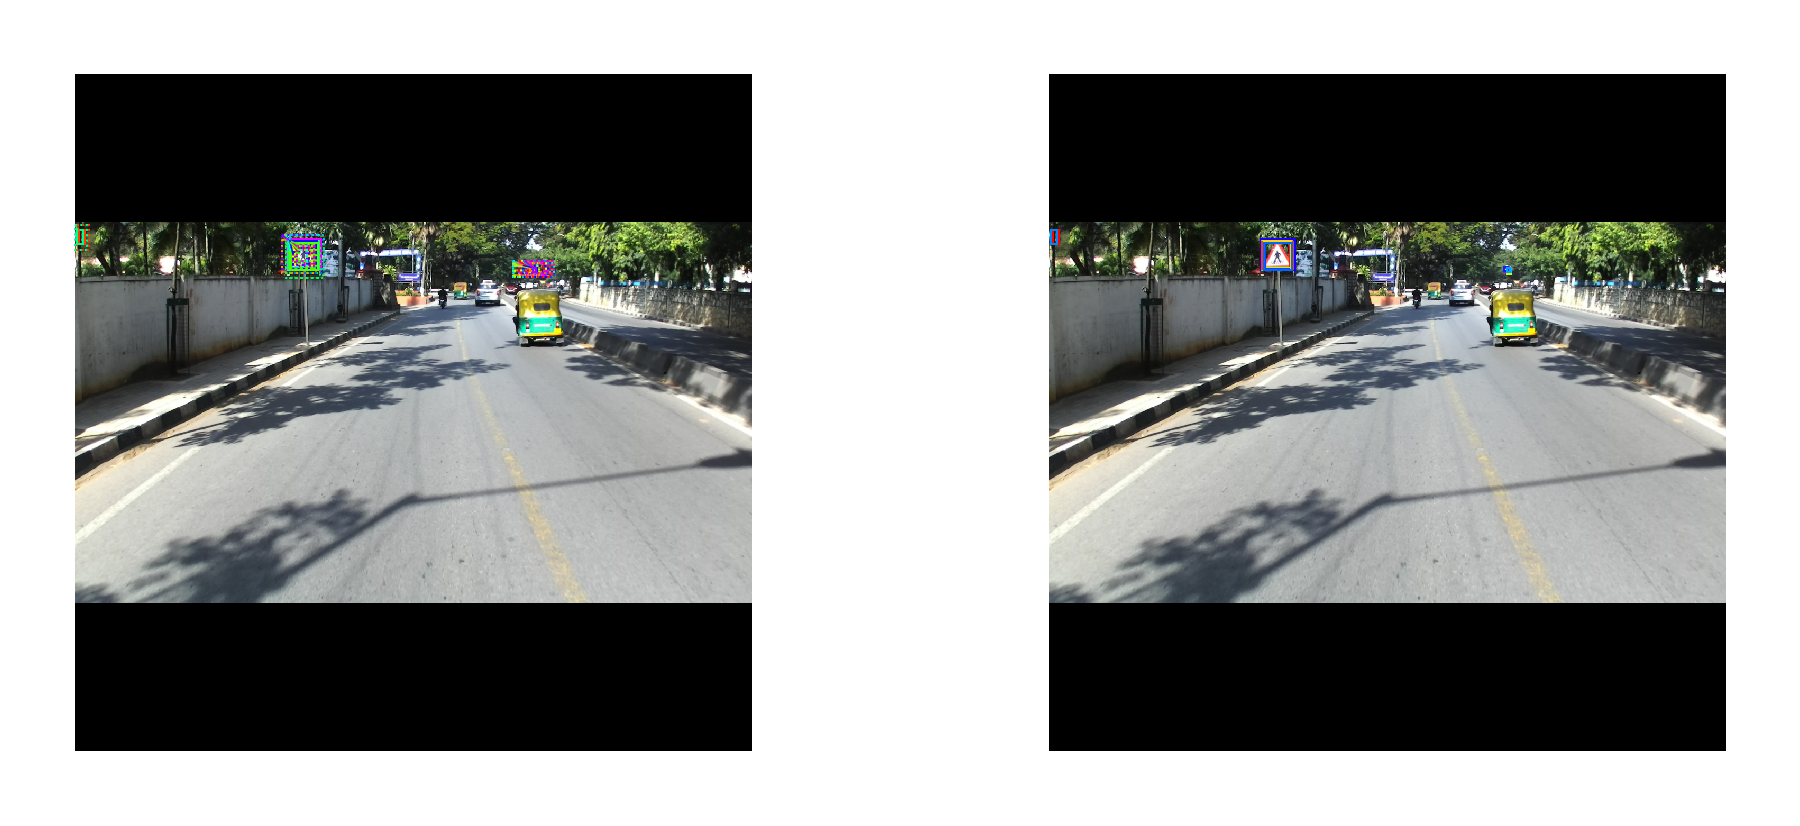

In [24]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

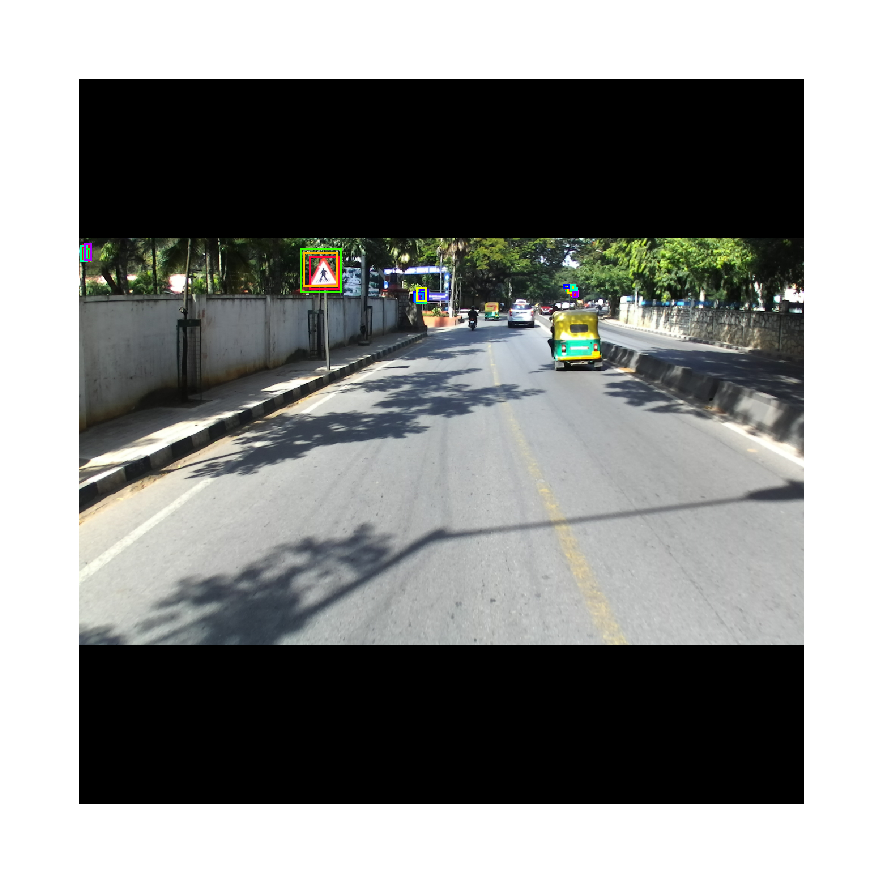

In [25]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

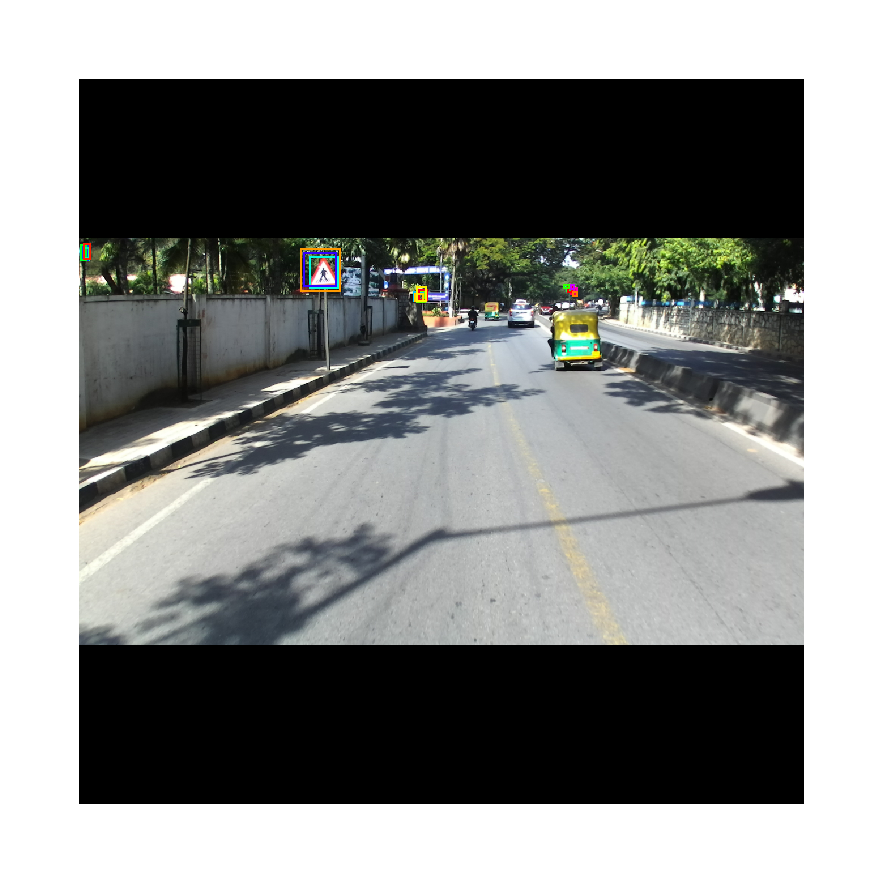

In [26]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = dnncfg.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [27]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


2020-01-09 15:00:54,671:[INFO]:[__main__.mrcnn.utils]:[utils.py:859 -       compute_recall() ]: Bbox IoU before filtering with threshold: overlaps: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
2020-01-09 15:00:54,674:[INFO]:[__main__.mrcnn.utils]:[utils.py:863 -       compute_recall() ]: iou_argmax: [327523  88958]
2020-01-09 15:00:54,675:[INFO]:[__main__.mrcnn.utils]:[utils.py:869 -       compute_recall() ]: Total matched gt_boxes (2.4437927663734115e-06)/Total gt_boxes(1) = recall(409200)
All Anchors (409200)       Recall: 0.000  Positive anchors: 1
2020-01-09 15:00:54,888:[INFO]:[__main__.mrcnn.utils]:[utils.py:859 -       compute_recall() ]: Bbox IoU before filtering with threshold: overlaps: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
2020-01-09 15:00:54,890:[INFO]:[__main__.mrcnn.utils]:[utils.py:863 -       compute_recall() ]: iou_argmax: [0 0]
2020-01-09 15:00:54,890:[INFO]:[__main__.mrcnn.utils]:[utils.py:869 -       compute_recall() ]: Total matched gt_boxes (0.0

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [28]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 4, 4)       min:   -3.54334  max:    4.23427  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    3.00000  float32


1 detections: ['traffic_sign']


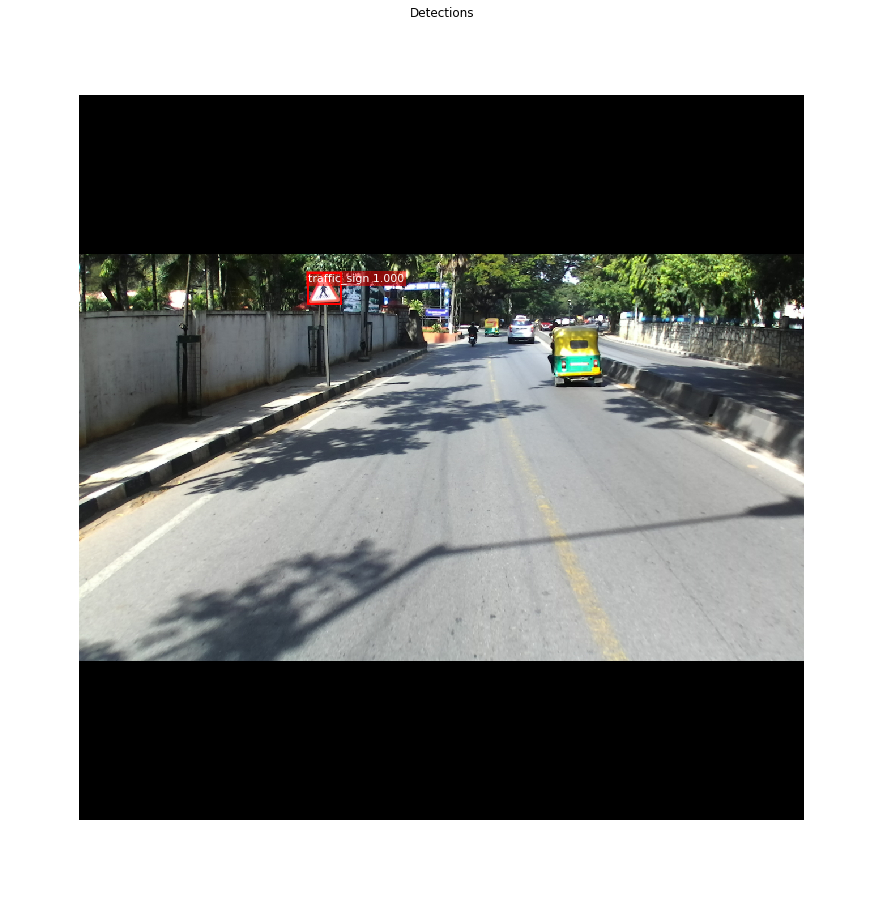

In [29]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [30]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = dnncfg.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
12 Positive ROIs
[('BG', 988), ('traffic_sign', 12)]


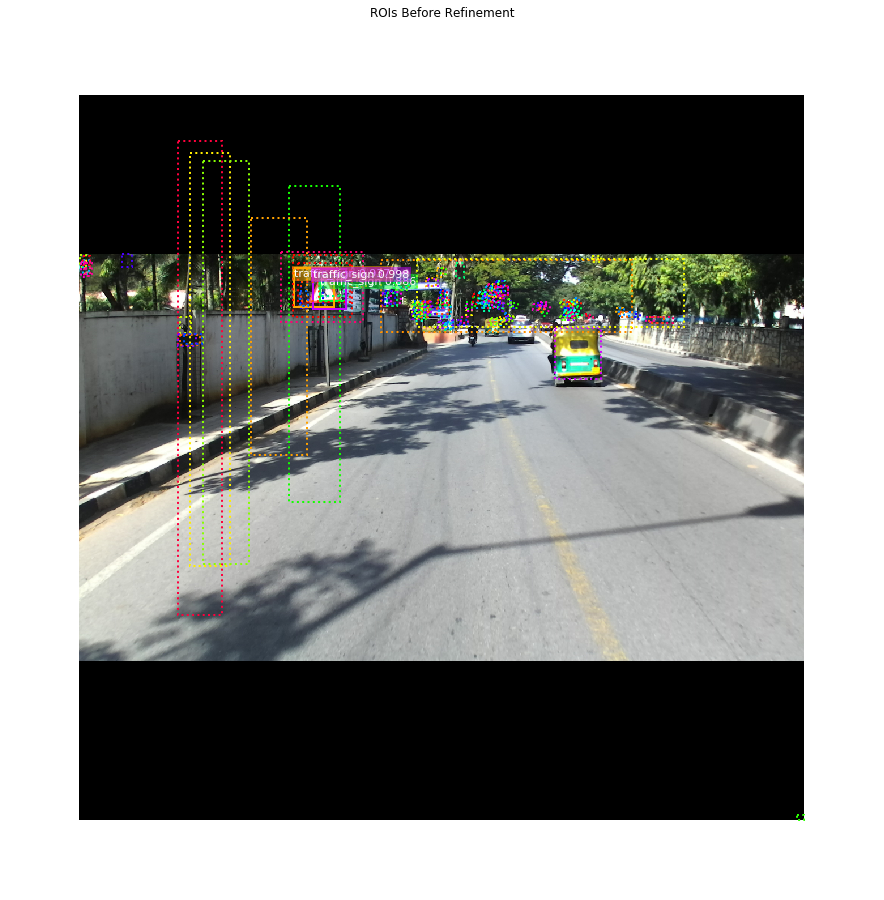

In [31]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -3.54334  max:    3.36087  float32
refined_proposals        shape: (1000, 4)             min: -418.00000  max: 1301.00000  int32


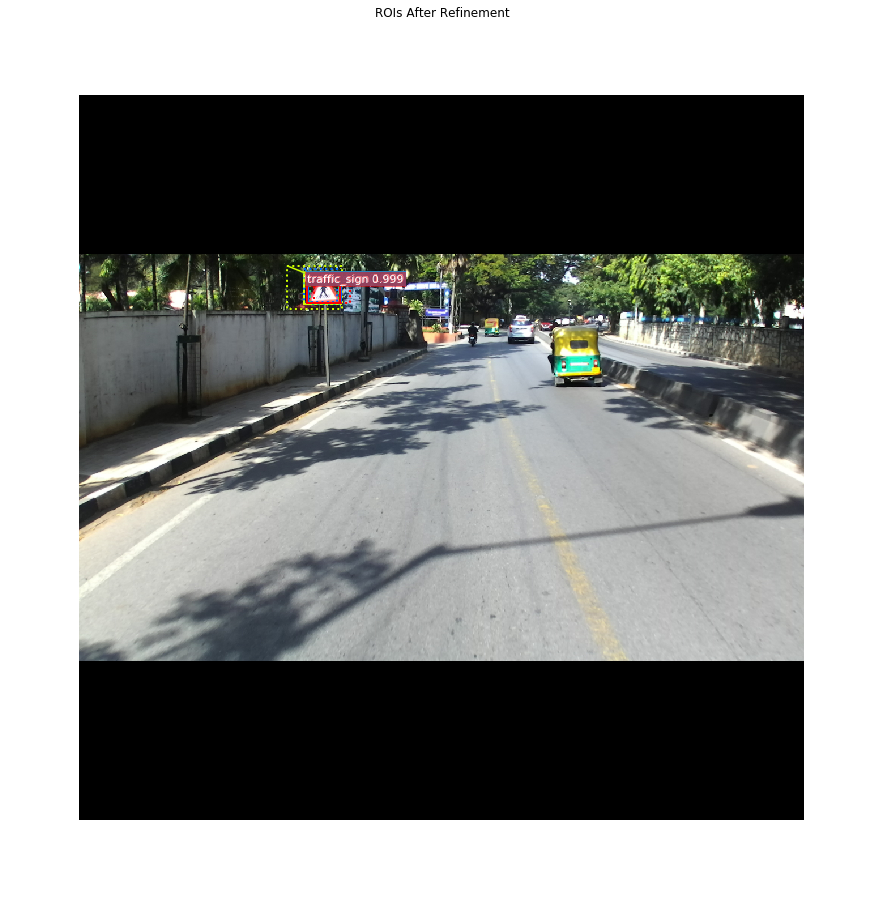

In [32]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * dnncfg.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [33]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 12 detections:
[  0  41  48  58  63 257 291 413 424 501 930 971]


In [34]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= dnncfg.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    dnncfg.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 9:
[  0  41  48  58  63 257 424 501 930]


#### Per-Class Non-Max Suppression

In [35]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            dnncfg.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

traffic_sign          : [  0  41  48  58  63 257 424 501 930] -> [41]

Kept after per-class NMS: 1
[41]


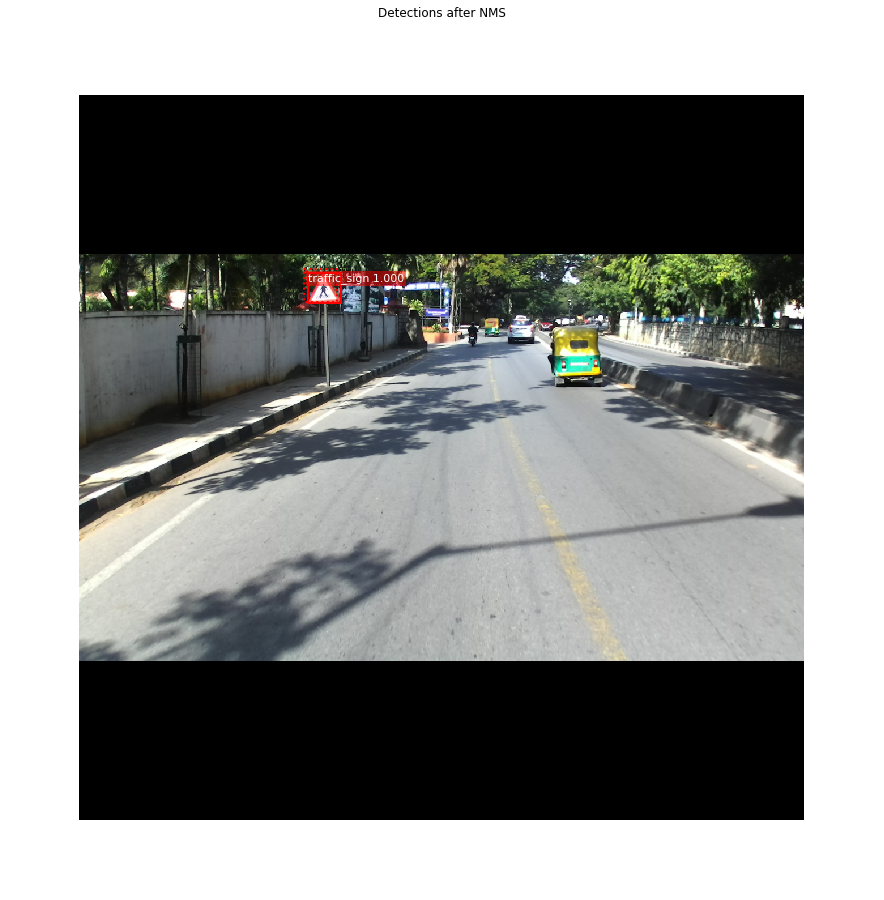

In [36]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

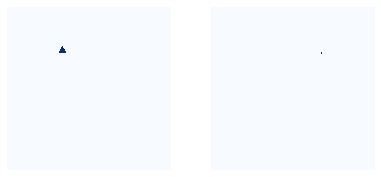

In [37]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [38]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    3.00000  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.00000  max:    1.00000  float32
1 detections: ['traffic_sign']


In [39]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (1, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (1, 1280, 1280)       min:    0.00000  max:    1.00000  bool


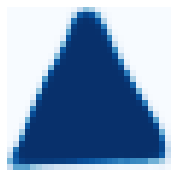

In [40]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

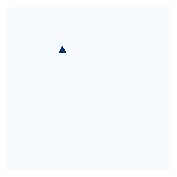

In [41]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [42]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1280, 1280, 3)    min: -123.70000  max:  151.10001  float32
res4w_out                shape: (1, 80, 80, 1024)     min:    0.00000  max:   53.37404  float32
rpn_bbox                 shape: (1, 409200, 4)        min:  -10.93934  max:   19.96297  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


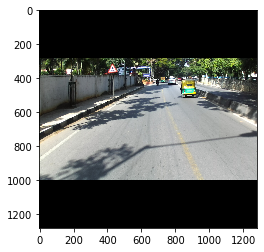

In [43]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],dnncfg))

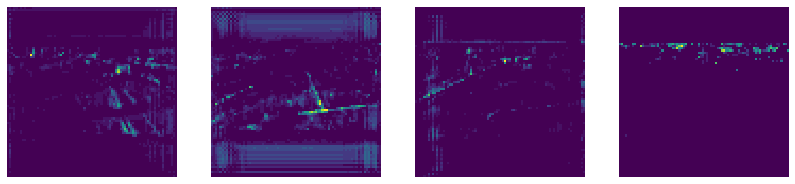

In [44]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

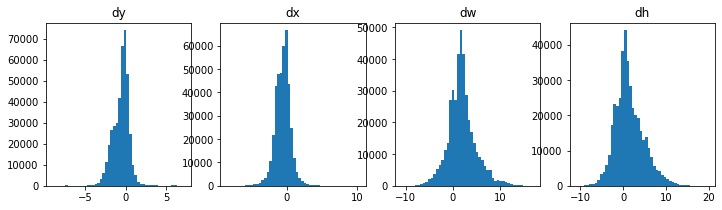

In [45]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

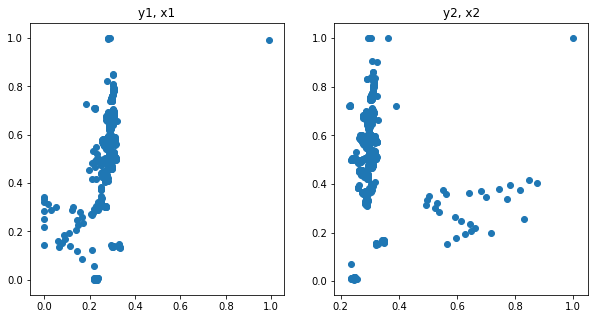

In [46]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()